<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session14/DepthModel_V3(Batch_wise_and_solve_glob).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!git clone https://github.com/Sushmitha-Katti/DepthModel

Cloning into 'DepthModel'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 245 (delta 124), reused 244 (delta 123), pack-reused 0
Receiving objects: 100% (245/245), 11.81 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [3]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DepthModel/nyu.h5

--2020-05-05 12:45:01--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.108.75
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.108.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DepthModel/nyu.h5’

./DepthModel/nyu.h5 100%[===================>] 164.89M  80.5MB/s    in 2.0s    

2020-05-05 12:45:03 (80.5 MB/s) - ‘./DepthModel/nyu.h5’ saved [172897376/172897376]



In [0]:
import zipfile

archive = zipfile.ZipFile('/content/gdrive/My Drive/Mask_Rcnn/Sushmitha/data_Part1.zip')

for file in archive.namelist():
    if file.startswith('Overlay1/Fg-Bg/'):
        archive.extract(file, '/content/')

In [5]:
! ls '/content/Overlay1/Fg-Bg/' | wc -l

80000


In [0]:
#with optimisation
from PIL import Image
a = Image.open("/content/Overlay1/Fg-Bg/fg-bg800.jpg")

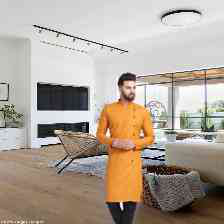

In [23]:
a

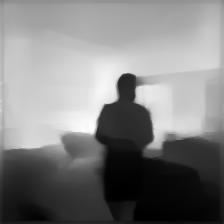

In [25]:
from PIL import Image
a = Image.open("/content/DepthModel/a.jpg")
a

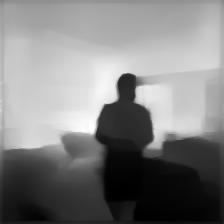

In [27]:
from PIL import Image
a = Image.open("/content/Depth_Part1/dept1.jpg")
a

In [4]:
%cd DepthModel


/content/DepthModel


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import notebook

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(path,start,end):
    loaded_images = []
    for i in range(start,end):
        x = np.clip(np.asarray(Image.open(f"{path}fg-bg{str(i)}.jpg" ).resize((448,448)), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True, start = 1):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('gray')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    print(shape)
    
    #all_images = []
    start = start
    for i in notebook.tqdm(range(outputs.shape[0]),desc = f"Loading from {start} images") :
    
        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
  
            #plt.figure(figsize=(2.24,2.24),dpi=100)
            matplotlib_image = plt.imshow(plasma(rescaled)[:,:,:3])
            pil_image = Image.fromarray(np.uint8( ( matplotlib_image.get_array()*255))).convert("L").resize((224,224))
            pil_image.save(f"/content/Depth_Part1/depth{str(start)}.jpg")
            plt.close() 
            start+=1

            # plt.imsave("a.jpg",plasma(rescaled)[:,:,:3])          

        
           

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
#from utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format("nyu.h5"))

# Input images
div = 200
num = 13001
for  i in range((80000-13000)//div):

  
  inputs = load_images(path ="/content/Overlay1/Fg-Bg/",start=num,end = num+div )
  print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))
# Compute results
  outputs = predict(model, inputs)
# Display results
  display_images(outputs.copy(), inputs.copy(), start = num)
  num+=div

print("done")

Loading model...

Model loaded (nyu.h5).

Loaded (200) images of size (448, 448, 3).


In [2]:
!ls Depth_Part1/ | wc -l

13000


In [4]:
%cd content/

/content


In [6]:
from zipfile import ZipFile 
import os 
  
def get_all_file_paths(directory): 
  
    # initializing empty file paths list 
    file_paths = [] 
  
    # crawling through directory and subdirectories 
    for root, directories, files in os.walk(directory): 
        for filename in files: 
            # join the two strings in order to form the full filepath. 
            filepath = os.path.join(root, filename) 
            file_paths.append(filepath) 
  
    # returning all file paths 
    return file_paths         
  
def main(): 
    # path to folder which needs to be zipped 
    directory = 'Depth_Part1'
  
    # calling function to get all file paths in the directory 
    file_paths = get_all_file_paths(directory) 
  
    # printing the list of all files to be zipped 
    print('Following files will be zipped:') 
    for file_name in file_paths: 
        print(file_name) 
  
    # writing files to a zipfile 
    with ZipFile('/content/gdrive/My Drive/Mask_Rcnn/Sushmitha/Depth_Part1','a') as zip: 
        # writing each file one by one 
        for file in file_paths: 
            zip.write(file) 
  
    print('All files zipped successfully!')         
  
  

main()


Streaming output truncated to the last 5000 lines.
Depth_Part1/depth3183.jpg
Depth_Part1/depth7122.jpg
Depth_Part1/depth6476.jpg
Depth_Part1/depth4590.jpg
Depth_Part1/depth1643.jpg
Depth_Part1/depth4361.jpg
Depth_Part1/depth10160.jpg
Depth_Part1/depth2680.jpg
Depth_Part1/depth4181.jpg
Depth_Part1/depth1690.jpg
Depth_Part1/depth1319.jpg
Depth_Part1/depth4631.jpg
Depth_Part1/depth9806.jpg
Depth_Part1/depth8279.jpg
Depth_Part1/depth5152.jpg
Depth_Part1/depth1531.jpg
Depth_Part1/depth1951.jpg
Depth_Part1/depth5930.jpg
Depth_Part1/depth741.jpg
Depth_Part1/depth10339.jpg
Depth_Part1/depth6779.jpg
Depth_Part1/depth6946.jpg
Depth_Part1/depth2253.jpg
Depth_Part1/depth8733.jpg
Depth_Part1/depth2257.jpg
Depth_Part1/depth657.jpg
Depth_Part1/depth10763.jpg
Depth_Part1/depth11048.jpg
Depth_Part1/depth2070.jpg
Depth_Part1/depth3656.jpg
Depth_Part1/depth6276.jpg
Depth_Part1/depth6138.jpg
Depth_Part1/depth10099.jpg
Depth_Part1/depth1732.jpg
Depth_Part1/depth5034.jpg
Depth_Part1/depth10548.jpg
Depth_Par